In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [2]:
train_path = "original_data/training"
validation_path = "original_data/validation"
test_path = "original_data/test"

In [3]:
dimentions = (299, 299)
batch_size = 64

n_class = 2

In [4]:
train_datagen  = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [5]:
valid_datagen  = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 717 images belonging to 2 classes.


In [7]:
validation_generator = valid_datagen.flow_from_directory(
    validation_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 239 images belonging to 2 classes.


In [8]:
test_generator = valid_datagen.flow_from_directory(
    test_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 239 images belonging to 2 classes.


In [9]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from keras.models import Model

base_model = InceptionV3(
    weights='imagenet', 
    include_top=False,
)

x = base_model.output 
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation='relu')(x) 
predictions = Dense(n_class, activation='softmax')(x)    
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
from keras import metrics

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [11]:
from keras.callbacks import ModelCheckpoint  

# !mkdir saved_models

model_file = 'saved_models/baseline_weights.best.InceptionV3.hdf5'
checkpointer = ModelCheckpoint(filepath=model_file, 
                               verbose=1, save_best_only=True)

In [12]:
epochs = 10

In [13]:
train_history = model.fit_generator(train_generator, 
                                    validation_data=validation_generator, 
                                    epochs=epochs, 
                                    callbacks=[checkpointer],
                                    steps_per_epoch=train_generator.samples // batch_size, 
                                    validation_steps=validation_generator.samples // batch_size
                                   )

Epoch 1/10
11/11 [==============================] - 140s 13s/step - loss: 0.4061 - acc: 0.8580 - val_loss: 0.5030 - val_acc: 0.7083

Epoch 00001: val_loss improved from inf to 0.50300, saving model to saved_models/baseline_weights.best.InceptionV3.hdf5
Epoch 2/10
11/11 [==============================] - 58s 5s/step - loss: 0.1223 - acc: 0.9542 - val_loss: 1.5201 - val_acc: 0.6971

Epoch 00002: val_loss did not improve from 0.50300
Epoch 3/10
11/11 [==============================] - 94s 9s/step - loss: 0.1037 - acc: 0.9577 - val_loss: 0.6320 - val_acc: 0.7771

Epoch 00003: val_loss did not improve from 0.50300
Epoch 4/10
11/11 [==============================] - 97s 9s/step - loss: 0.1227 - acc: 0.9575 - val_loss: 0.2043 - val_acc: 0.9086

Epoch 00004: val_loss improved from 0.50300 to 0.20434, saving model to saved_models/baseline_weights.best.InceptionV3.hdf5
Epoch 5/10
11/11 [==============================] - 95s 9s/step - loss: 0.0686 - acc: 0.9628 - val_loss: 1.4702 - val_acc: 0.729

In [14]:
train_history.history

{'val_loss': [0.5029961466789246,
  1.5201146078109742,
  0.6320480292184012,
  0.2043379032611847,
  1.4702302018801372,
  0.1186346903869084,
  0.12461295012916837,
  0.4269487619400024,
  0.8958050409952799,
  2.0213493640082225],
 'val_acc': [0.7083333333333334,
  0.6971428506714957,
  0.7771428632736206,
  0.9085714319774083,
  0.7291666666666666,
  0.9428571442195347,
  0.9657142870766776,
  0.8857142911638533,
  0.8333333333333334,
  0.8228571489879063],
 'loss': [0.4061406823721799,
  0.12932204843639963,
  0.09900227846266847,
  0.0916782634911822,
  0.07187362796531428,
  0.058687142614356515,
  0.035663173327173975,
  0.07373699894999289,
  0.09452060389847339,
  0.07447773968917852],
 'acc': [0.8579545454545454,
  0.9509954058192955,
  0.9601837673194558,
  0.9709035224790412,
  0.9601837672281777,
  0.9831546707503829,
  0.9816232771822359,
  0.9724349158646319,
  0.9663093415920438,
  0.9678407351601909]}

In [35]:
import matplotlib.pyplot as plt

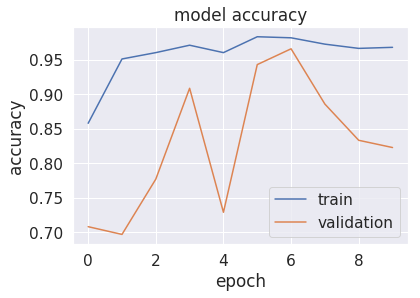

In [38]:
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

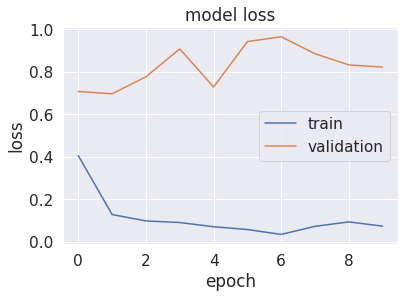

In [39]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [15]:
tesr_result = model.evaluate_generator(test_generator, steps=10)

In [16]:
tesr_result

[2.1471381096950064, 0.8052805279544478]

In [17]:
predict = model.predict_generator(test_generator,steps = 10)

In [19]:
import cv2
import numpy as np


from keras.preprocessing import image
# img = cv2.imread(path_to_one_file)
# img = np.array([img]).reshape((1, 3, 299, 299))

def to_tensor(img_path): 
    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255. 
    
    return img_tensor

In [24]:
def make_predict(img_path): 
    class_dic = {}
    for k, v in test_generator.class_indices.items():
        class_dic[v] = k
    
    
    y_prob = model.predict(to_tensor(img_path))
    y_classes = y_prob.argmax(axis=-1)
    return class_dic[y_classes[0]]

In [25]:
img_path = "original_data/test/benign/ISIC_0004472.jpg"
make_predict(img_path)

'benign'

In [43]:
class_dic = dict(test_generator.class_indices)
print(class_dic)

one_hot = {}
for k, v in test_generator.class_indices.items():
    one_hot[v] = k
print(one_hot)

{'benign': 0, 'malignant': 1}
{0: 'benign', 1: 'malignant'}


In [28]:
from os import listdir 

y_true = [] 
y_pred = []

class_name = "benign"
for img in listdir("original_data/test/{}/".format(class_name)):
    img_path = "original_data/test/{}/{}".format(class_name, img)
    pred = make_predict(img_path)
    
    y_true.append(class_name)
    y_pred.append(pred)
    
class_name = "malignant"
for img in listdir("original_data/test/{}/".format(class_name)):
    img_path = "original_data/test/{}/{}".format(class_name, img)
    pred = make_predict(img_path)
    
    y_true.append(class_name)
    y_pred.append(pred)
    

In [29]:
len(y_true) == len(y_pred)

True

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=["benign", "malignant"])

In [31]:
import pandas as pd
df_cm = pd.DataFrame(cm, ["benign", "malignant"], ["benign", "malignant"])

In [32]:
import seaborn as sn

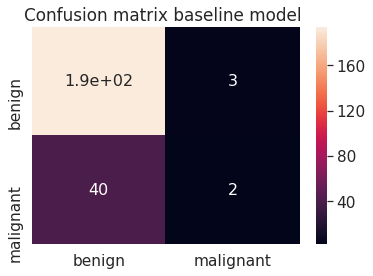

In [41]:
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}).set_title("Confusion matrix baseline model")# font size
plt.show()

In [46]:
from sklearn.metrics import f1_score
y_true_01 = [class_dic[p] for p in y_true]
y_pred_01 = [class_dic[p] for p in y_pred]
f1_score(y_true_01, y_pred_01)

0.0851063829787234